In [29]:
from validation.TensileExperimental import TensileExperimental
from validation.BendingExperimental import BendingExperimental
import numpy as np
from scipy.optimize import minimize,basinhopping
import pandas as pd

In [30]:
r = BendingExperimental()

df       = r["df"]
df_stats = r["df_stats"]

# Get the data
layers = df_stats["layers"]
layers[0] = ["Y","Y"]
df_stats["layers"] = layers

ni = df_stats["ni"]
ni[0] = 2
df_stats["ni"] = ni

delta = df_stats["v [X,SX,Y,SY]"]
delta[0] = [0,0,2,0]
df_stats["v [X,SX,Y,SY]"] = delta

C:\Users\djoroya\AppData\Local\Temp\ipykernel_16148\778930764.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layers[0] = ["Y","Y"]
C:\Users\djoroya\AppData\Local\Temp\ipykernel_16148\778930764.py:8: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  layers[0] = ["Y","Y"]
C:\Users\djoroya\AppData\Local\Temp\ipykernel_16148\778930764.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ni[0] = 2
C:\Users\djoroya\AppData\Local\Temp\

In [31]:
df_stats.round(2)

Eb [GPa]       t [mm]       b [mm]       Sb [MPa]              layers  \
         mean   std   mean   std   mean   std     mean    std                
Name                                                                         
TFP1    13.20  0.63   5.27  0.06  25.60  0.10   135.00  18.94       [Y, Y]   
TFP2     9.87  0.78   4.70  0.00  25.57  0.06   117.43  15.76       [Y, X]   
TFP3     9.22  0.50   4.83  0.06  25.40  0.17   128.05   5.34      [Y, SX]   
TFP4    10.18  0.77   4.70  0.00  25.67  0.15   141.70   7.53      [Y, SY]   
TFP5     6.14  0.16   5.70  0.00  25.17  0.15   107.43   3.90  [Y, SX, SY]   
TFP6     7.80  0.33   5.60  0.00  25.03  0.64   114.31  11.80   [Y, X, SY]   

     v [X,SX,Y,SY] ni  
                       
Name                   
TFP1  [0, 0, 2, 0]  2  
TFP2  [1, 0, 1, 0]  2  
TFP3  [0, 1, 1, 0]  2  
TFP4  [0, 0, 1, 1]  2  
TFP5  [0, 1, 1, 1]  3  
TFP6  [1, 0, 1, 1]  3

In [32]:
12/15

0.8

In [33]:
# only thin 

ni = df_stats["ni"].values
tau_exp = df_stats["t [mm]"]["mean"].values

tau_pred_fcn = lambda tn,tl: tn + 2*tl*ni

In [34]:
from validation.experimental import  nucleo
E_nucleo_exp_Mpa = nucleo()["young modulus [MPa]"]
E_nucleo_exp = E_nucleo_exp_Mpa/1000
print(E_nucleo_exp)

0.8


In [35]:
from validation.experimental import manual_data

t_nucleo_exp = manual_data()["t_nucleo [mm]"]

In [36]:
# min square error


def objective(tn,tl):
    return sum(((tau_pred_fcn(tn,tl) - tau_exp)/tau_exp )**2)

x0 = [0,0]
#
x0 = 2*np.random.rand(2)

bound  = [(0.95*t_nucleo_exp, t_nucleo_exp*1.05), # tn
          (0, None)] # tl




tn_opt = 2.934
tl_opt = 0.475



In [37]:
print("Optimal tn: ", tn_opt)
print("Optimal tl: ", tl_opt)

tau_pred = tau_pred_fcn(tn_opt,tl_opt)

Optimal tn:  2.934
Optimal tl:  0.475


In [38]:
# Tau predicted
print("Tau predicted: ", tau_pred)
print("Tau experimental: ", tau_exp)

df_exp = pd.DataFrame({"tau_exp": tau_exp, "tau_pred": tau_pred})
df_exp["error [%]"] = 100*abs(df_exp["tau_exp"] - df_exp["tau_pred"]) / df_exp["tau_exp"]
# round to 2 decimals
df_exp = df_exp.round(2)
df_exp

Tau predicted:  [4.834 4.834 4.834 4.834 5.784 5.784]
Tau experimental:  [5.26666667 4.7        4.83333333 4.7        5.7        5.6       ]


,tau_exp,tau_pred,error [%]
0,5.27,4.83,8.22
1,4.70,4.83,2.85
2,4.83,4.83,0.01
3,4.70,4.83,2.85
4,5.70,5.78,1.47
5,5.60,5.78,3.29


In [54]:
def modelSX(E_resina, E_carbon):
    return 0.00e+00 + \
           1.53e-03*E_resina + \
           1.08e-05*E_carbon - \
           4.04e-08*E_resina**2 + \
           3.70e-09*E_resina*E_carbon - \
           8.65e-11*E_carbon**2

def modelSY(E_Resina,E_Carbon):
    return 0.00e+00 + \
           1.51e-03*E_Resina + \
           1.20e-05*E_Carbon - \
           3.83e-08*E_Resina**2 + \
           3.48e-09*E_Resina*E_Carbon - \
           8.10e-11*E_Carbon**2

def ModelY(E_resina,E_carbon):
    v_frac = 0.3575
    E = (1- v_frac)*E_resina + v_frac*E_carbon
    return E

def ModelX(E_resina,E_carbon):
    t_l = 0.475 #  Espesor de la capa [mm]
    A_s = 0.283 # mm^2
    L =10 # mm
    r = 3*t_l/8 
    d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]

    f_c = 6*(d+2*r)/L
    E_h = 1/(f_c/E_carbon + (1-f_c)/E_resina)
    E = (2*E_resina*(t_l - 2*r) + 2*E_h*r)/t_l
    return E

In [55]:
from AnalyticalLayers.models import E_flexion

In [56]:
def E_effective_j(En,Eresina,Efibra,j):
    

    layers = df_stats["layers"].iloc[j]
    # unique 
    layers = list(dict.fromkeys(layers))
    
    E_SX = modelSX(Eresina,Efibra)
    E_SY = modelSY(Eresina,Efibra)
    E_X  = ModelX(Eresina,Efibra)
    E_Y  = ModelY(Eresina,Efibra)

    E_l = np.array([ E_X, E_SX, E_Y, E_SY])
        

    return E_flexion(En,E_l,tn_opt,tl_opt,layers,gamma= 0.8)

def E_effective(En,Eresina,Efibra):

    return np.array([E_effective_j(En,Eresina,Efibra,j) for j in range(len(df_stats))])


In [57]:
df_stats

Eb [GPa]              t [mm]               b [mm]            \
           mean       std      mean       std       mean       std   
Name                                                                 
TFP1  13.201050  0.630858  5.266667  0.057735  25.600000  0.100000   
TFP2   9.869501  0.780113  4.700000  0.000000  25.566667  0.057735   
TFP3   9.222003  0.495965  4.833333  0.057735  25.400000  0.173205   
TFP4  10.181815  0.770635  4.700000  0.000000  25.666667  0.152753   
TFP5   6.143105  0.161637  5.700000  0.000000  25.166667  0.152753   
TFP6   7.798060  0.334186  5.600000  0.000000  25.033333  0.635085   

        Sb [MPa]                  layers v [X,SX,Y,SY] ni  
            mean        std                                
Name                                                       
TFP1  134.996667  18.942693       [Y, Y]  [0, 0, 2, 0]  2  
TFP2  117.430000  15.759607       [Y, X]  [1, 0, 1, 0]  2  
TFP3  128.053333   5.337905      [Y, SX]  [0, 1, 1, 0]  2  
TFP4  141.703333   7.525386      [Y, SY]  [0, 0, 1, 1]  2  
TFP5  107.433333   3.902939  [Y, SX, SY]  [0, 1, 1, 1]  3  
TFP6  114.306667  11.800790   [Y, X, SY]  [1, 0, 1, 1]  3

In [58]:
E_eff_exp = df_stats["Eb [GPa]"]["mean"].values

Eresina = 100 # GPa
Efibra = 2000 # GPa
En_0 = 1000

E_eff_pred = E_effective(En_0,Eresina,Efibra)

In [59]:
from validation.experimental import  nucleo
E_nucleo_exp_Mpa = nucleo()["young modulus [MPa]"]
E_nucleo_exp = E_nucleo_exp_Mpa/1000
print(E_nucleo_exp)

0.8


In [60]:
# minimize 
def objective_E(En,Eresina,Efibra):

    # E_SX and E_SY similar 
    # dE_S = Evec[1] - Evec[3]
    dE =   Eresina - Efibra
    # Efibra > Eresina
    return sum((E_effective(En,Eresina,Efibra) - E_eff_exp)**2) + \
               1e4*np.max([0,dE])**2 

x0 = np.random.rand(3)
# must be positive 
# v [X,SX,Y,SY]
eps = 0.001
bounds = [  (E_nucleo_exp*0.9,1.1*E_nucleo_exp), # En
            (eps,None), # Evec[0]   # Eresina
            (eps,None), # Evec[1]   # Efibra
            ]

minimize_kwargs = { 
    'method':'Nelder-Mead',
    'bounds': bounds
}

res = basinhopping(lambda x: objective_E(x[0],x[1],x[2]),
                x0, 
                minimizer_kwargs=minimize_kwargs,
                niter=50)


En_opt = res.x[0]
Eresina_opt = res.x[1]
Efibra_opt = res.x[2]


E_eff_pred = E_effective(En_opt,Eresina_opt,Efibra_opt)

c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\.conda\Lib\site-packages\scipy\optimize\_basinhopping.py:294: OptimizeWarning: Initial guess is not within the specified bounds
  return self.minimizer(self.func, x0, **self.kwargs)


In [61]:
Evec_opt = np.array([ModelX(Eresina_opt,Efibra_opt),
                        modelSX(Eresina_opt,Efibra_opt), 
                        ModelY(Eresina_opt,Efibra_opt), 
                        modelSY(Eresina_opt,Efibra_opt)])

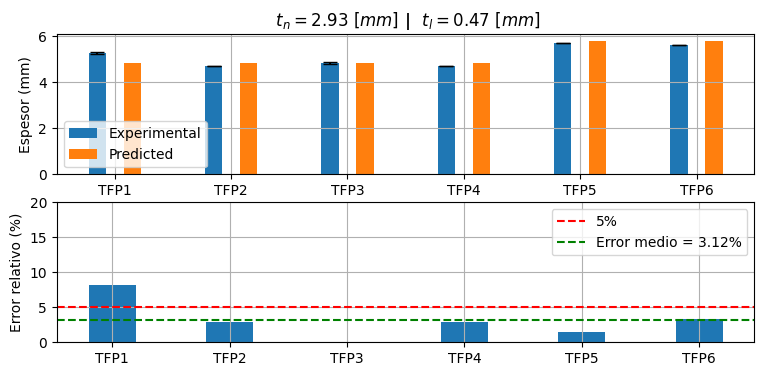

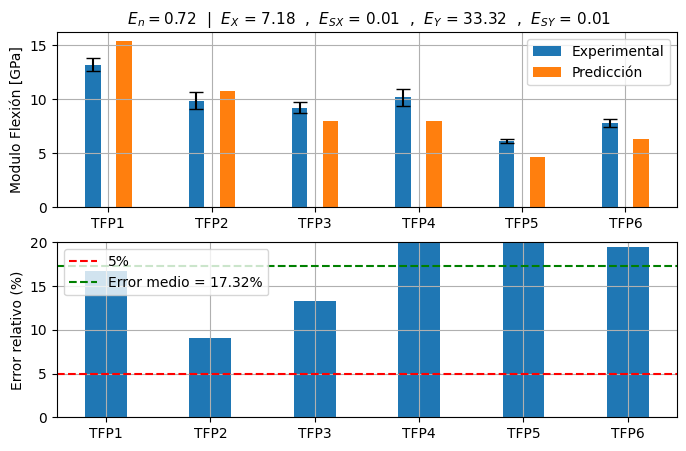

In [62]:
from AnalyticalLayers.plot_E_flex import plot_E
from AnalyticalLayers.plt_thin import plt_thin

plt_thin(df_stats, tau_exp, tau_pred, tn_opt, tl_opt)
plot_E(df_stats, E_eff_exp, E_eff_pred, Evec_opt, En_opt)

In [63]:
print("Optimal En: ", En_opt)
print("Optimal Evec: ", Evec_opt)
print("Optimal tn: ", tn_opt)
print("Optimal tl: ", tl_opt)

Optimal En:  0.7200000000000001
Optimal Evec:  [7.17999084e+00 6.42210967e-03 3.33178636e+01 6.45451223e-03]
Optimal tn:  2.934
Optimal tl:  0.475


In [70]:
df_layers = pd.DataFrame({"Evec [GPa]": Evec_opt}, index=["X","SX","Y","SY"])
# add nuclueo
df_layers.loc["Nucleo"] = [En_opt]
df_layers.round(4)

,Evec [GPa]
X,7.1800
SX,0.0064
Y,33.3179
SY,0.0065
Nucleo,0.7200


In [65]:
df_thickness = pd.DataFrame({"t [mm]": [tn_opt, tl_opt]}, index=["Nucleo","Capas"])

df_thickness.round(2)

,t [mm]
Nucleo,2.93
Capas,0.48


In [66]:
df_mat = pd.DataFrame({"E [GPa]": [Eresina_opt, Efibra_opt]}, index=["Resina","Fibra"])
df_mat.round(2)

,E [GPa]
Resina,3.59
Fibra,86.75


In [67]:
df_pred = {
    "Name"          : df_stats.index,
    "E pred [GPa]"  : E_eff_pred,
    "E exp [GPa]"   : E_eff_exp,
    "E e rel [%]"   : 100*abs(E_eff_exp - E_eff_pred)/E_eff_exp,
    "t pred [mm]"   : tau_pred,
    "t exp [mm]"    : tau_exp,
    "t e rel [%]"   : 100*abs(tau_exp - tau_pred)/tau_exp
}
df_pred = pd.DataFrame(df_pred)
# decimals1
df_pred = df_pred.round(2)
df_pred

,Name,E pred [GPa],E exp [GPa],E e rel [%],t pred [mm],t exp [mm],t e rel [%]
0,TFP1,15.41,13.20,16.75,4.83,5.27,8.22
1,TFP2,10.76,9.87,9.02,4.83,4.70,2.85
2,TFP3,8.00,9.22,13.28,4.83,4.83,0.01
3,TFP4,8.00,10.18,21.46,4.83,4.70,2.85
4,TFP5,4.67,6.14,23.97,5.78,5.70,1.47
5,TFP6,6.28,7.80,19.43,5.78,5.60,3.29


In [68]:
Em_error = np.mean(df_pred["E e rel [%]"])
tm_error = np.mean(df_pred["t e rel [%]"])

from loadsavejson.savejson import savejson

savejson({"layers":df_layers, 
            "errors": {"E":Em_error, "t":tm_error},
          "thickness":df_thickness},
          "df_opt_fix_thin.json")